<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/Attention/chatbot_using_seq2seq_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파일 올리기

In [5]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving 2.png to 2.png
User uploaded file "2.png" with length 158713 bytes


In [3]:
from IPython.display import Image

구글 마운트

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Building a chatbot using sequence-to-sequence neural networks with attention

우리는 인간이 입력한 자연 언어에 대해 답변이 될 수 있는 문장을 생성하는 챗봇을 만들어 보고자 한다.

In [8]:
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import absolute_import
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

# 1 dataset

우리는 영화 대본의 dataset을 사용한다. 이것은 두 명 이상의 등장인물들 간의 대화로 구성된다.

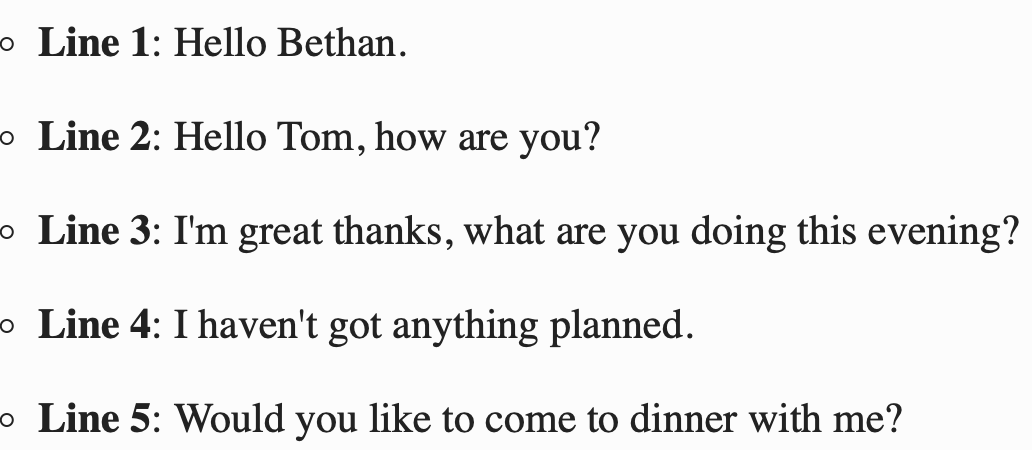

In [4]:
Image('1.png',width=600)

우리는 입력값으로 입력되는 n-1 번째 줄의 대사에 대하여, 출력값으로 출력되는 n 번째 줄의 대사가 답해지는 모델을 만들고자 한다.

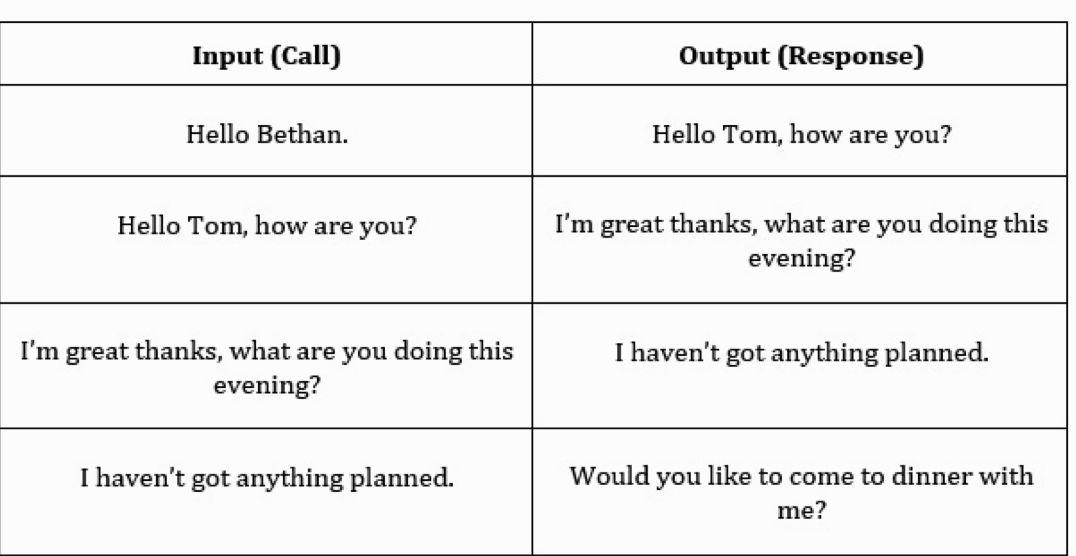

In [7]:
Image('2.png',width=600)

## 1.1 corpus 가져오기

In [10]:
corpus = "movie_corpus"
corpus_name = "movie_corpus"
datafile = os.path.join(corpus, "/content/drive/My Drive/NLP/corpus/formatted_movie_lines.txt")

In [11]:
with open(datafile, 'rb') as file:
    lines = file.readlines()
    
for line in lines[:3]:
    print(str(line) + '\n')

b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\n"

b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\n"

b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"



# 2 Preprocessing

## 2.1 Creating Vocabulary (단어집합 만들기)

- w2i  
- w2c (count)  
- i2w  

Default values:  

- pad_token   
- sos  
- eos     
> empty vocabs

In [28]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Vocabulary:

    def __init__(self,name):

        self.name = name
        self.trimmed = False
        self.w2i={}
        self.w2c={}
        self.i2w = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3

    def addWord(self, w):

        """
        - 만약 새 단어가 단어 집합 내에 없다면, 우리는 그 단어를 우리의 indices에 추가한다.
        그리고 그 단어의 카운트를 1로 두고, 그것이 또 추가될 때마다 1 씩 단어 집합 내에서 추가(증가)한다.

        -  만약 단어가 이미 단어 집합 내에 있다면, 그 단어의 카운트를 단지 1 증가시킨다.
        """
        if w not in self.w2i: # 단어집합의 index 내에 없는 단어라면,

            self.w2i[w]=self.num_words # 인덱스화된 해당 단어의 개수를 카운트한다
            self.w2c[w] = 1 # 새 단어가 1 로 카운트 됨
            self.i2w[self.num_words] = w # 
            self.num_words += 1 # 위에서 단어화된 해당 단어에 대하여, 카운트 해준다
        
        else:
            self.w2c[w] += 1 # 단어집합의 index 내에  있는 단어라면, 해당 단어의 카운트를 1 증가시킨다.

    def addSentence(self, sent): # 주어진 문장 내의 모든 단어를 추가하게 해주는 함수

        for word in sent.split(' '):
            self.addWord(word)

    """
    학습 시 모델의 학습 속도를 빠르게 해주는 하나의 방법은 "단어집합의 사이즈를 줄이는 것"이다.
    이것은 임베딩 계층이 학습되는 모수의 총 개수를 더 작을 것이라는 것을 의미한다.

    위의 것을 수행할 하나의 간단한 방법은 단어집합 내에서 "low-freq words"를 제거하는 것이다.
    단어 집합 내에서 단지 한두번 나타난 단어는 예측을 할 때 지배적인 역할을 하지 못할 것 같다. 우리는 
    이런 단어들을 제거하거나 blank로 대치할 것이다.
    """

    def trim(self, min_cnt): 

        if self.trimmed:

            return 
        self.trimmed = True
            
        words_to_keep=[] # 사용자가 설정한 min_cnt 보다 높은 words를 추가할 리스트 생성

        for k, v in self.w2c.items():

            if v >= min_cnt:

                words_to_keep.append(k) # 추가할 리스트의 인덱스들을 어펜드

        print('Words to Keep: {} / {} = {:.2%}'.format(
            len(words_to_keep), len(self.w2i), len(words_to_keep) / len(self.w2i)))

        """
        인덱스들은 이제 새로운 words_to_keep 리스트에서 다시 만들어진다.
        우리는 이제 모든 인덱스를 "초기의 empty 값"에 두고, loop 를 통해
        그것들을 다시 population 시킨다.
        """

        self.w2i={}
        self.w2c={}
        self.i2w={PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}

        self.num_words = 3

        for w in words_to_keep:
            self.addWord(w)

### items 설명: 

 이것은 딕셔너리의 키, 값을 튜플로 묶은 객체를 반환한다.

In [16]:

test = {'1':1,'2':2}
print(test.items())
print(test)

print(type(test.items()))
print(test)

dict_items([('1', 1), ('2', 2)])
{'1': 1, '2': 2}
<class 'dict_items'>
{'1': 1, '2': 2}


## 2.2 Others

- 유니코드 -> 아스키
- 클린징  
- vocabs 읽기  
- filtering  
- data loading

In [29]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def cleanString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

def readVocs(datafile, corpus_name):
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    pairs = [[cleanString(s) for s in l.split('\t')] for l in lines]
    voc = Vocabulary(corpus_name)
    return voc, pairs

def filterPair(p, max_length):
    return len(p[0].split(' ')) < max_length and len(p[1].split(' ')) < max_length

def filterPairs(pairs, max_length):
    return [pair for pair in pairs if filterPair(pair, max_length)]

def loadData(corpus, corpus_name, datafile, max_length):
    voc, pairs = readVocs(datafile, corpus_name)
    print(str(len(pairs)) + " Sentence pairs")
    pairs = filterPairs(pairs,max_length)
    print(str(len(pairs))+ " Sentence pairs after trimming")
    for p in pairs:
        voc.addSentence(p[0])
        voc.addSentence(p[1])
    print(str(voc.num_words) + " Distinct words in vocabulary")
    return voc, pairs

In [30]:
max_length = 10 
voc, pairs = loadData(corpus, corpus_name, datafile, max_length)

221282 Sentence pairs
64271 Sentence pairs after trimming
18008 Distinct words in vocabulary


In [31]:
print("Example Pairs:")
for pair in pairs[-10:]:
    print(pair)

Example Pairs:
['four', 'three minutes to go !']
['three minutes to go !', 'yes .']
['another fifteen seconds to go .', 'do something ! stall them !']
['yes sir name please ?', 'food !']
['food !', 'do you have a reservation ?']
['do you have a reservation ?', 'food ! !']
['grrrhmmnnnjkjmmmnn !', 'franz ! help ! lunatic !']
['what o clock is it mr noggs ?', 'eleven o clock my lorj']
['stuart ?', 'yes .']
['yes .', 'how quickly can you move your artillery forward ?']


## 2.3 드문 단어들 제거  
  
전술했듯이, 드문 단어들을 단어 집합 내에서 제거함으로써, 우리는 학습 시간을 줄일 수 있다.

In [33]:
def removeRareWords(voc, all_pairs, minimum):
    voc.trim(minimum)
    
    pairs_to_keep = []
    
    for p in all_pairs:
        keep = True
        
        for word in p[0].split(' '):
            if word not in voc.w2i:
                keep = False
                break
        for word in p[1].split(' '):
            if word not in voc.w2i:
                keep = False
                break

        if keep:
            pairs_to_keep.append(p)

    print("Trimmed from {} pairs to {}, {:.2%} of total".format(len(all_pairs)\
        , len(pairs_to_keep), len(pairs_to_keep)/ len(all_pairs)))
    return pairs_to_keep


minimum_count = 3
pairs = removeRareWords(voc, pairs, minimum_count)

Trimmed from 64271 pairs to 53165, 82.72% of total


## 2.4 Others 2

- 문장에서 인덱스 추출  
- 제로 패딩  
- input var  
- 매스킹 얻기  
- output var  
- batch2train